In [1]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications.resnet import ResNet50

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

/tmp/ipykernel_9832/2589756750.py:5: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.0)
  from scipy import ndimage
2025-10-27 11:31:00.784053: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-27 11:31:00.807562: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-27 11:31:00.807576: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-27 11:31:00.808423: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to regi

#### Experiment #1 : RGB layer

In [2]:
model = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

2025-10-27 11:31:01.740348: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-27 11:31:01.780064: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-27 11:31:01.781525: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
model.layers[2].kernel_size

(7, 7)

In [4]:
f = model.layers[2].get_weights()

In [5]:
f[0].shape

(7, 7, 3, 64)

2025-10-27 11:31:03.175153: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-10-27 11:31:03.175171: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-10-27 11:31:03.175185: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-10-27 11:31:03.175200: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before

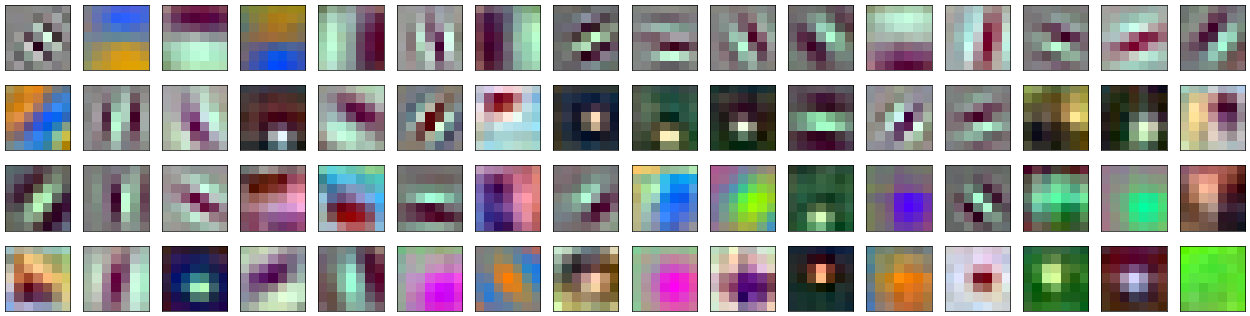

In [6]:



filters, _ = model.layers[2].get_weights()

#fig = plt.figure(figsize=(15, 90))
fig, axes = plt.subplots(ncols = filters.shape[-1]//4, nrows=4, figsize=(16, 4))
axes = axes.flatten()
mags = []

syms = []
antis = [] 
fs = []


s, a = getSymAntiSymTF(filters)
#theta = getSobelTF(filters)
a_energy = reduce_euclidean_norm(a, axis=[0,1])**2
s_energy = reduce_euclidean_norm(s, axis=[0,1])**2
total_energy  = reduce_euclidean_norm(filters, axis=[0,1])**2
#beta = a_energy/total_energy
beta = tf.reduce_mean(a_energy/total_energy, (0))

for i in range(filters.shape[-1]):
    fs.append((filters[:,:, :,i], beta[i]))

fs = sorted(fs, key=lambda f: f[1], reverse=True)  

#axses = axes.flatten(order='F')[0]
for i , (f, beta) in enumerate(fs):
    #print(beta)

    ax = axes[i]

    #anti_norm  =  (anti - anti.min())/(anti.max() - anti.min()) #pre.MinMaxScaler(copy=False).fit_transform(x).reshape(3,3,3)
    #sym_norm  =  (sym - sym.min())/(sym.max() - sym.min()) #pre.MinMaxScaler(copy=False).fit_transform(x).reshape(3,3,3)
    f_norm  =  (f - f.min())/(f.max() - f.min()) #pre.MinMaxScaler(copy=False).fit_transform(x).reshape(3,3,3)

    #ax.set_title(f" beta={beta:.3f}")
    ax.imshow(f_norm)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    ax.set_box_aspect(1)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

plt.show()


In [7]:
os.makedirs('figures', exist_ok=True)


fig.savefig('figures/resnet_rgb.pdf', dpi=600)
plt.show()